In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
from pathlib import Path
import warnings

from critdd import Diagram
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

In [2]:
dataset_names = {37:"Diabetes",
                 61:"Iris",
                 42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 187:"Wine Origin",
                 "segmentation": "Customer Segmentation",
                 "player":"Football Player"}

label_mapping = {"psl_prebin":"PSL",
                "msl_prebin":"MSL",
                "msl_prebin_nb" : "Naïve Bayes",
                "msl_prebin_miss": r"MISS$_{1800}$",
                "msl_prebin_miss90": r"MISS$_{90}$",
                "msl_prebin_logreg" : "Logistic Regression",
                "msl_prebin_random_forest": "Random Forest",
                "msl_prebin_xgboost": "XGBoost",
                }

hue_order = ["psl_prebin","msl_prebin", "msl_prebin_nb","msl_prebin_miss90","msl_prebin_miss", "msl_prebin_logreg","msl_prebin_random_forest","msl_prebin_xgboost"]

In [3]:
def load_results(folder, folds=None):
    df = pd.concat((pd.read_csv(f) for f in Path(folder).glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
    df = df.drop("params",axis=1)
    df["test_brier"] = -df["test_brier"]
    df["train_brier"] = -df["train_brier"]
    df = df[df.fold<folds if folds is not None else np.inf]
    df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")
    return df
df = load_results("results_90s_miss",20)
df.loc[df.clf_variant == "msl_prebin_miss", "clf_variant"] = "msl_prebin_miss90"
try:
    df2 = load_results("results",20)
    df = pd.concat((df, df2.loc[df2.clf_variant == "msl_prebin_miss"]))
except:
    pass

In [4]:
df.clf_variant.unique().tolist(), df.dataset.unique().tolist()

(['msl_prebin',
  'msl_prebin_nb',
  'msl_prebin_logreg',
  'msl_prebin_xgboost',
  'msl_prebin_random_forest',
  'msl_prebin_miss90',
  'psl_prebin',
  'msl_prebin_miss'],
 [61, 42900, 41945, 'player', 37, 187, 'segmentation'])

In [5]:
df.columns

Index(['dataset', 'fold', 'clf', 'score_set', 'fit_time', 'score_time',
       'test_acc', 'train_acc', 'test_aaacc', 'train_aaacc', 'test_bacc',
       'train_bacc', 'test_ece', 'train_ece', 'test_roc', 'train_roc',
       'test_brier', 'train_brier', 'test_recall', 'train_recall',
       'test_recall_at_wloss', 'train_recall_at_wloss', 'test_prec',
       'train_prec', 'test_spec_at_wloss', 'train_spec_at_wloss', 'test_f1',
       'train_f1', 'test_ent', 'train_ent', 'test_cov', 'train_cov',
       'test_eff', 'train_eff', 'n_features', 'stage', 'clf_variant'],
      dtype='object')

# Experiment 1

In [6]:
datasets = [42900, 41945,37]
clfs = [ "psl_prebin","msl_prebin", "msl_prebin_miss", "msl_prebin_nb"]

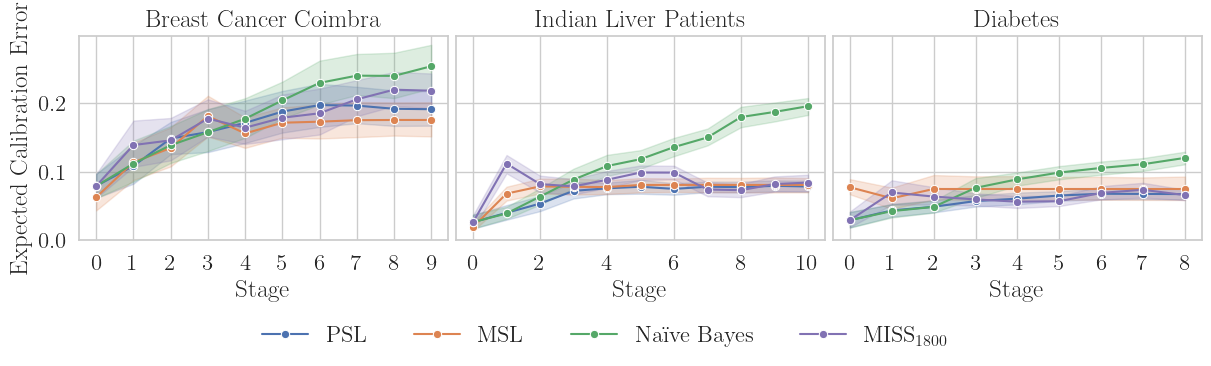

In [7]:
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')

metric= "ece"

for index, (dataset,ax) in enumerate(zip(datasets,axes.ravel())):
    df_ = df[(df.dataset == dataset)
    & (df.clf_variant.isin(clfs))
    & (~df.stage.isnull())]
    hue_order_ = [clf_variant if clf_variant in set(df_.clf_variant.unique()) else None for  clf_variant in hue_order]
    sns.lineplot(data=df_, x="stage", y=f"test_{metric}", hue="clf_variant", marker="o", ax=ax, hue_order=hue_order_)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel("Expected Calibration Error")
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig(f"fig/binary_{metric}.pdf", bbox_inches='tight')

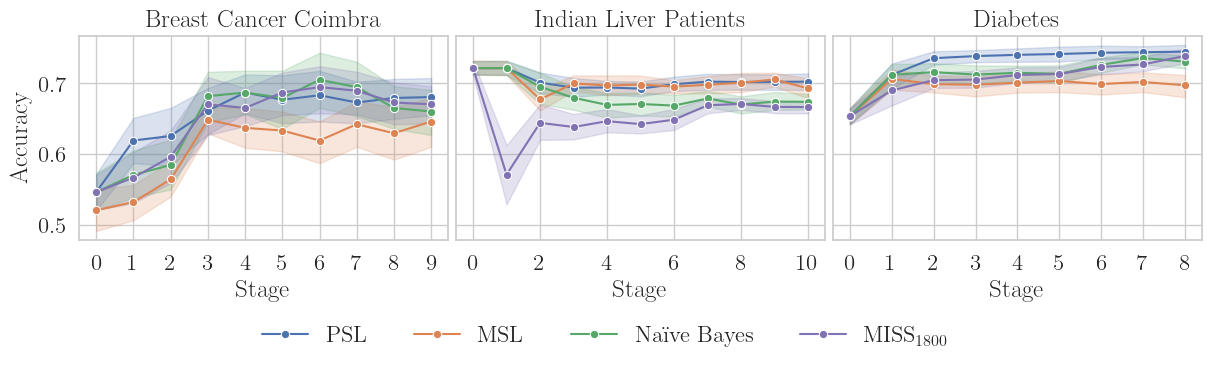

In [8]:
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')

metric= "acc"

for index, (dataset,ax) in enumerate(zip(datasets,axes.ravel())):
    df_ = df[(df.dataset == dataset)
    & (df.clf_variant.isin(clfs))
    & (~df.stage.isnull())]
    hue_order_ = [clf_variant if clf_variant in set(clfs) else None for  clf_variant in hue_order]
    sns.lineplot(data=df_, x="stage", y=f"test_{metric}", hue="clf_variant", marker="o", ax=ax, hue_order=hue_order_)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig(f"fig/binary_{metric}.pdf", bbox_inches='tight')

# Experiment 2

In [10]:
datasets = [187,"player","segmentation"]
clfs = ["msl_prebin", "msl_prebin_miss", "msl_prebin_logreg", "msl_prebin_nb", "msl_prebin_xgboost", "msl_prebin_random_forest"]
hue_order_ = [clf_variant if clf_variant in set(clfs) else None for  clf_variant in hue_order]

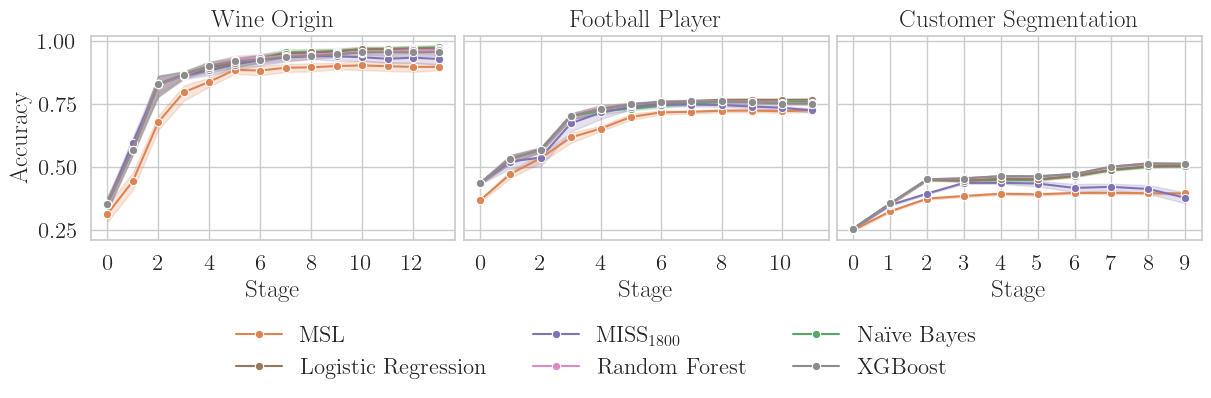

In [11]:
fig, axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')

metric= "acc"

for index, (dataset,ax) in enumerate(zip(datasets,axes.ravel())):
    df_ = df[(df.dataset == dataset)
    & (df.clf_variant.isin(clfs))
    & (~df.stage.isnull())]
    sns.lineplot(data=df_, x="stage", y=f"test_{metric}", hue="clf_variant", marker="o", ax=ax, hue_order = hue_order_)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

labels = [label_mapping[label] for label in labels]
order = [0,3,2,4,1,5]
handles = np.array(handles)[order]
labels = np.array(labels)[order]

lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig(f"fig/mc_{metric}.pdf", bbox_inches='tight')

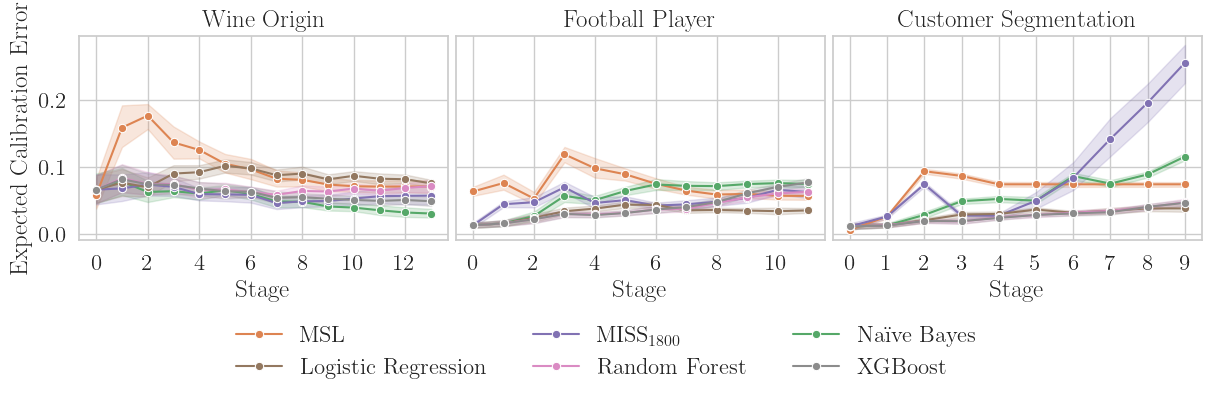

In [12]:
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')

metric= "ece"

for index, (dataset,ax) in enumerate(zip(datasets,axes.ravel())):
    df_ = df[(df.dataset == dataset)
    & (df.clf_variant.isin(clfs))
    & (~df.stage.isnull())]
    sns.lineplot(data=df_, x="stage", y=f"test_{metric}", hue="clf_variant", marker="o", ax=ax, hue_order = hue_order_)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel("Expected Calibration Error")
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

labels = [label_mapping[label] for label in labels]
order = [0,3,2,4,1,5]
handles = np.array(handles)[order]
labels = np.array(labels)[order]

lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig(f"fig/mc_{metric}.pdf", bbox_inches='tight')

In [13]:
clfs = ["msl_prebin","msl_prebin_miss90", "msl_prebin_miss"]
hue_order_ = [clf_variant if clf_variant in set(clfs) else None for  clf_variant in hue_order]

/tmp/ipykernel_3626875/2039224256.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_mapping[item.get_text()] for item in ax.get_xticklabels()])


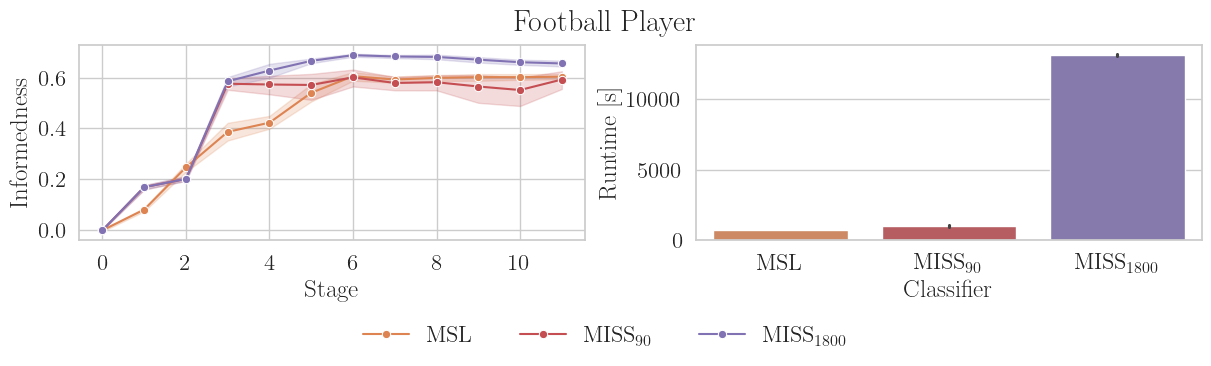

In [14]:
datasets = ["player"]
fig,axes = plt.subplots(1,len(datasets)+1, sharey=False, layout='constrained')
axes = axes.ravel()

ax = axes[0]

df_ = df[(df.dataset == datasets[0])
& (df.clf_variant.isin(clfs))
& (~df.stage.isnull())]
sns.lineplot(data=df_, x="stage", y="test_bacc", hue="clf_variant", marker="o", ax=ax, hue_order=hue_order_)    
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_ylabel("Informedness")
ax.set_xlabel("Stage")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax = axes[1]

df_ = df[(df.dataset.isin(["player"]))
         & (df.clf_variant.isin(clfs))
].dropna(subset="fit_time").groupby(["dataset","fold","clf", "clf_variant"]).sum()
sns.barplot(data=df_, y="fit_time", x="clf_variant", hue="clf_variant", ax=ax, hue_order=hue_order_, order=clfs)
ax.set_ylabel("Runtime [s]")
ax.set_xlabel("Classifier")
ax.set_xticklabels([label_mapping[item.get_text()] for item in ax.get_xticklabels()])

labels = [label_mapping[label] for label in labels]
fig.suptitle(dataset_names[datasets[0]])
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/runtime.pdf", bbox_inches='tight')